In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 4

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [26]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
adata_pred_ood.X[adata_pred_ood.X<0] = 0 
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [27]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [28]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [29]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [30]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [31]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [32]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [33]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [34]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [35]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [36]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


In [50]:
sc.tl.rank_genes_groups(adata_full, "condition", method="wilcoxon", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_g

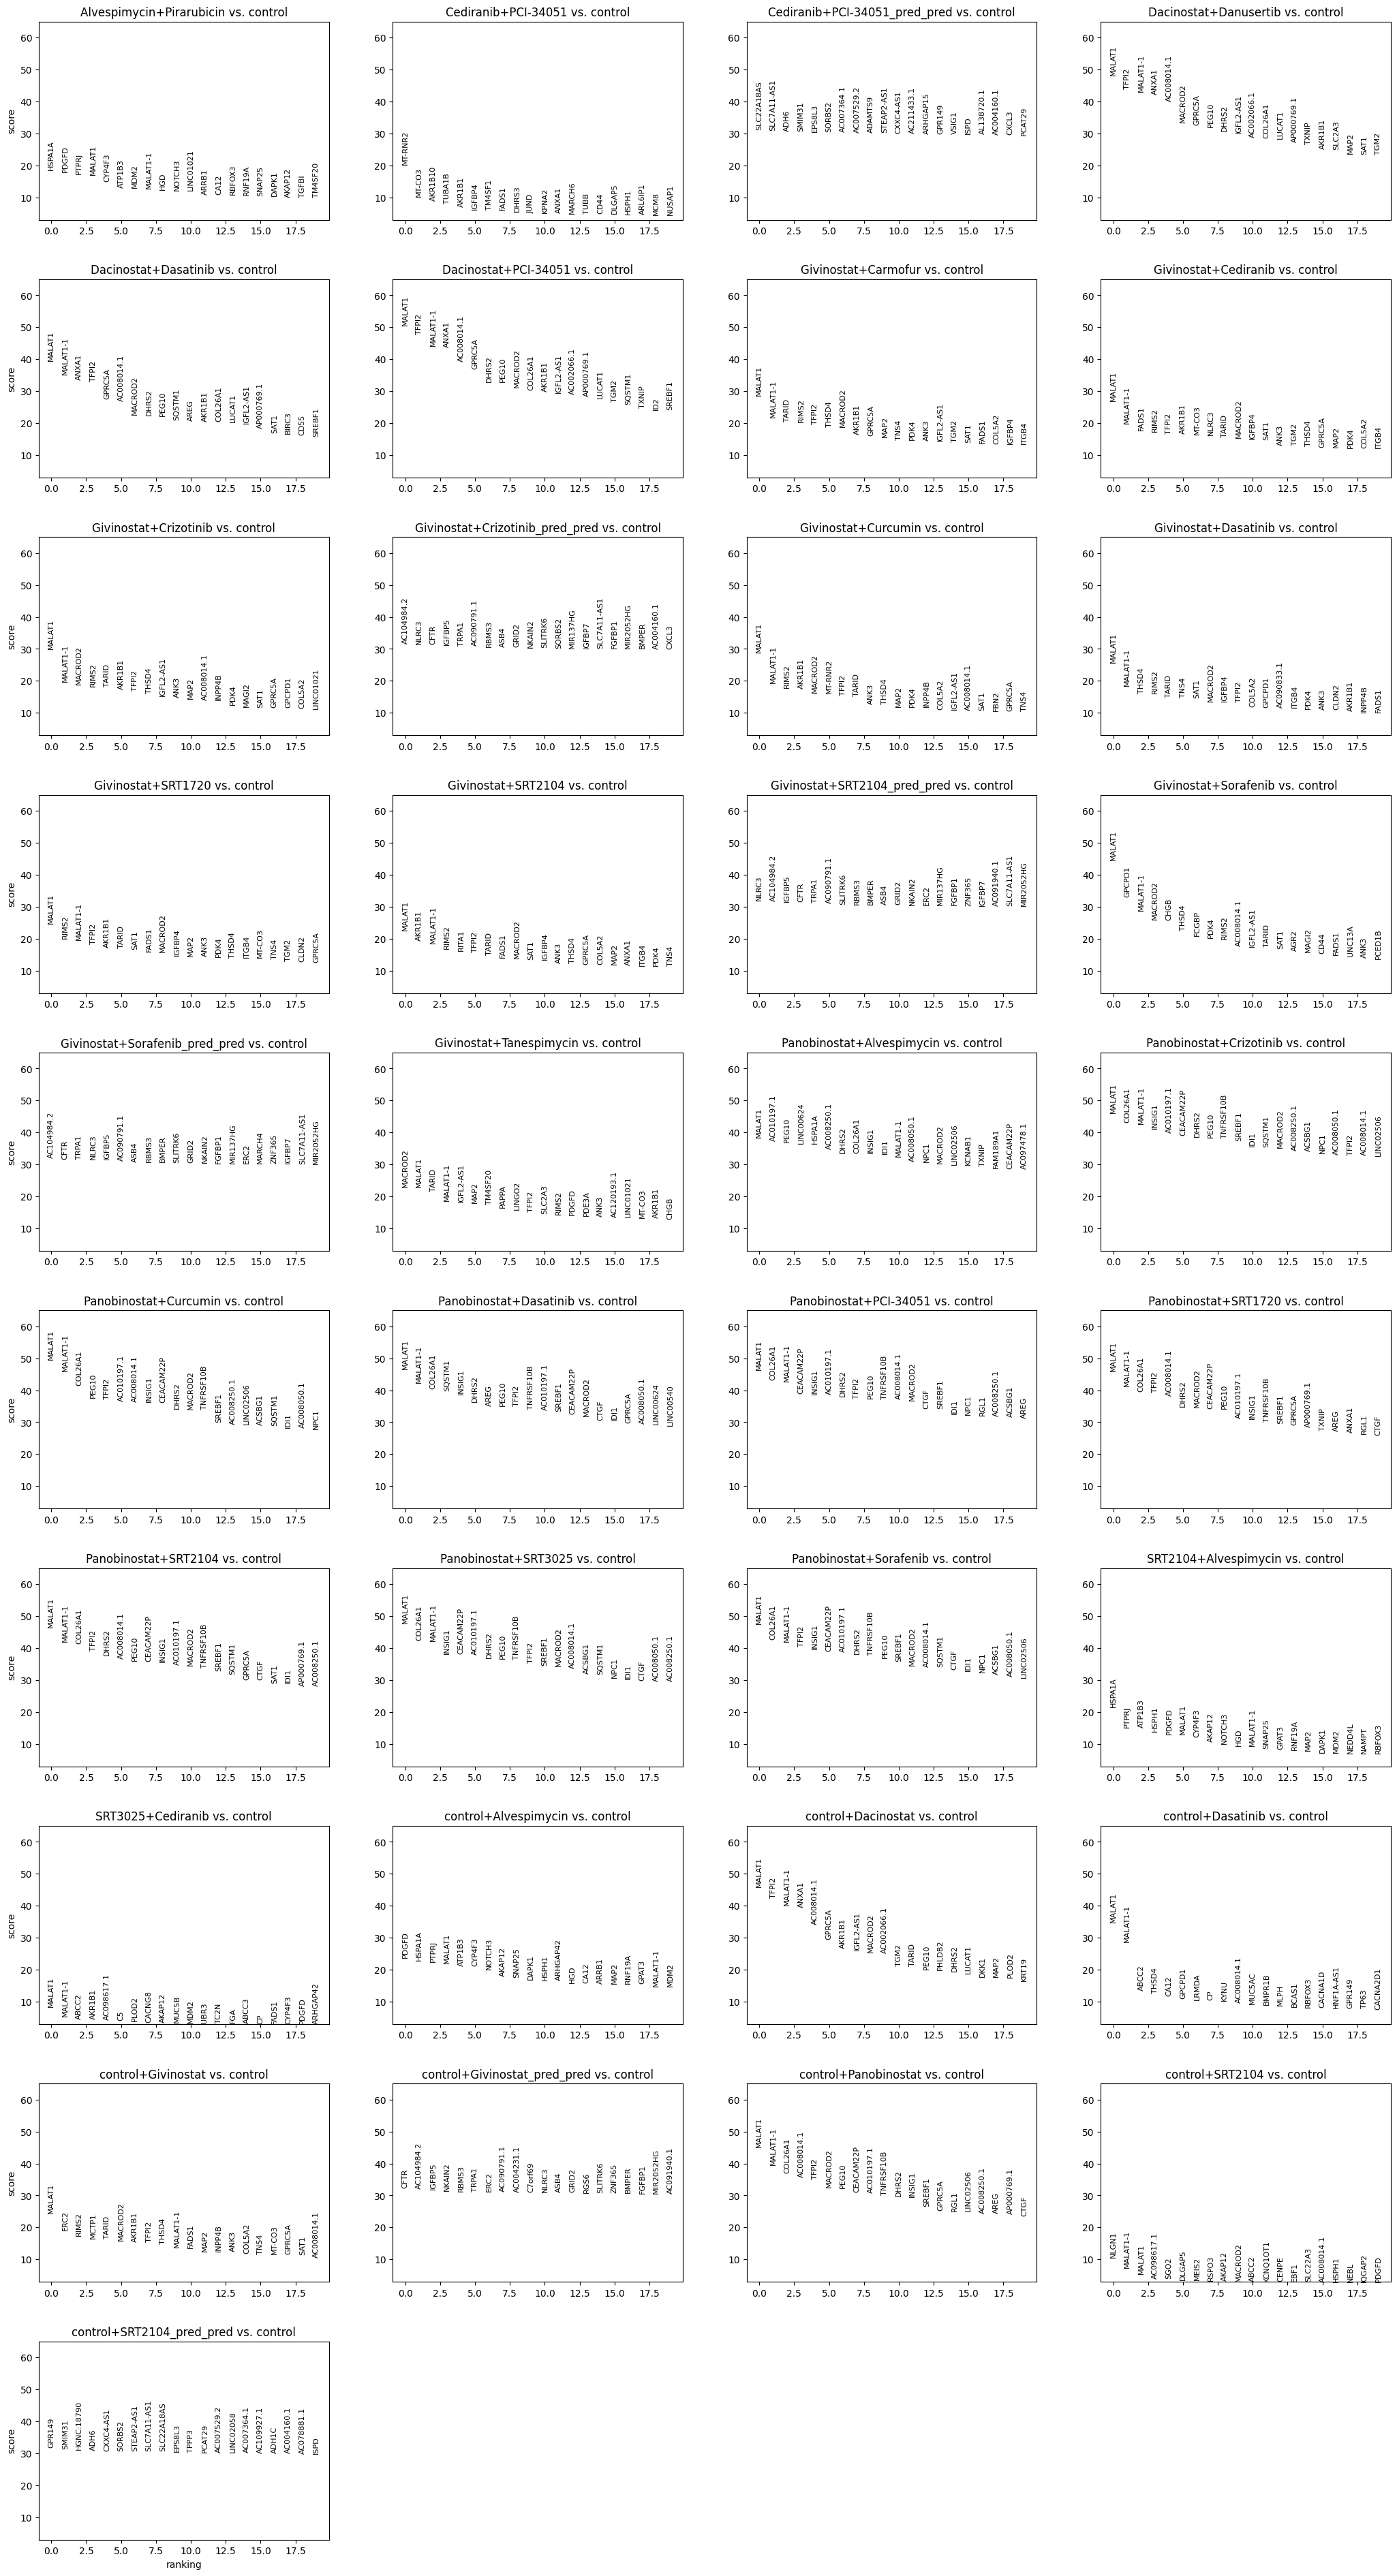

In [51]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [52]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [53]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_896704/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [54]:
gene_sets_ccnb1_pathway = reactome[reactome["genesymbol"]=="CCNB1"]["geneset"].values

In [55]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gene_sets_ccnb1_pathway)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [56]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Cediranib+PCI-34051_pred_pred', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Crizotinib_pred_pred', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+SRT2104_pred_pred', 'Givinostat+Sorafenib', 'Givinostat+Sorafenib_pred_pred', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Givinostat_pred_pred', 'control+Panobinostat', 'control+SRT2104', 'control+SRT2104_pred_pred'])

In [57]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_CELL_CYCLE,-0.845859,-1.966120,0.000000
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,-0.922004,-1.668755,0.000000
REACTOME_M_PHASE,-0.890271,-1.757895,0.000000
REACTOME_MITOTIC_METAPHASE_AND_ANAPHASE,-0.905136,-1.656470,0.000000
REACTOME_MITOTIC_PROMETAPHASE,-0.923761,-1.729557,0.000000
REACTOME_CELL_CYCLE_MITOTIC,-0.884384,-1.975802,0.000000
REACTOME_G2_M_CHECKPOINTS,-0.933418,-1.636860,0.002320
REACTOME_CELL_CYCLE_CHECKPOINTS,-0.842028,-1.719920,0.002375
REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION,-0.890927,-1.504485,0.011287


In [58]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_CELL_CYCLE']["pval"]
    res_score[cond] = df.loc['REACTOME_CELL_CYCLE']["score"]
    res_norm[cond] = df.loc['REACTOME_CELL_CYCLE']["norm"]

In [59]:
res_score

{'Alvespimycin+Pirarubicin': -0.84585863,
 'Cediranib+PCI-34051': 0.81720537,
 'Cediranib+PCI-34051_pred_pred': -0.37491435,
 'Dacinostat+Danusertib': -0.84701884,
 'Dacinostat+Dasatinib': -0.8508673,
 'Dacinostat+PCI-34051': -0.84975517,
 'Givinostat+Carmofur': -0.8391654,
 'Givinostat+Cediranib': -0.84254426,
 'Givinostat+Crizotinib': -0.8440502,
 'Givinostat+Crizotinib_pred_pred': -0.62663245,
 'Givinostat+Curcumin': -0.7995015,
 'Givinostat+Dasatinib': -0.85394466,
 'Givinostat+SRT1720': -0.71781886,
 'Givinostat+SRT2104': -0.7599537,
 'Givinostat+SRT2104_pred_pred': -0.61660826,
 'Givinostat+Sorafenib': -0.9251088,
 'Givinostat+Sorafenib_pred_pred': -0.6113422,
 'Givinostat+Tanespimycin': -0.8742434,
 'Panobinostat+Alvespimycin': -0.7515377,
 'Panobinostat+Crizotinib': -0.77344066,
 'Panobinostat+Curcumin': -0.804501,
 'Panobinostat+Dasatinib': -0.7849226,
 'Panobinostat+PCI-34051': -0.789106,
 'Panobinostat+SRT1720': -0.80906725,
 'Panobinostat+SRT2104': -0.78187776,
 'Panobinost

In [60]:
pd.DataFrame(res_score, index=[0]).to_csv(f"gse_score_{split}.csv")